<a href="https://colab.research.google.com/github/snoop2head/covid19_unknown_spread/blob/master/forecast_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p>
Prepared by Vytautas Bielinskas. 2020. <br>
Download data from: https://finance.yahoo.com/quote/GOOG/history/
</p>

<h2>PART 1. Data Pre-processing</h2>

<h3>Step #0. Fire the system</h3>

In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [2]:
!git clone https://github.com/snoop2head/covid19_unknown_spread.git

fatal: destination path 'covid19_unknown_spread' already exists and is not an empty directory.


In [3]:
%cd covid19_unknown_spread/

/content/covid19_unknown_spread


In [4]:
!ls -a

.			      .git	       README.md
..			      .gitignore       track_unknown_paths.ipynb
dataset			      img	       weights.h5
dataset_predict		      korean-calendar  wrangle_prediction.ipynb
forecast_seoul_covid19.ipynb  logs


<h3>Step #1. Read data</h3>

In [5]:
# Importing Training Set
dataset_train = pd.read_csv('./dataset_predict/df_train.csv')
dataset_train = dataset_train.fillna("0")
dataset_train.head()

,date,new_confirmed,new_untracked,new_no_paths,is_holiday,is_weekend,gov_policy
0,2020-01-24,1,0,0,1,1,0
1,2020-01-25,0,0,0,1,1,0
2,2020-01-26,0,0,0,1,1,0
3,2020-01-27,0,0,0,0,0,0
4,2020-01-28,0,0,0,0,0,0


In [6]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:5]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (239, 7)
All timestamps == 239
Featured selected: ['new_confirmed', 'new_untracked', 'new_no_paths', 'is_holiday']


<h3>Step #2. Data pre-processing</h3>
<p>
Removing all commas and convert data to matrix shape format.
</p>

In [7]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')
        dataset_train[i][j] = dataset_train[i][j].replace('True', '1')
        dataset_train[i][j] = dataset_train[i][j].replace('False', '0')

dataset_train = dataset_train.astype(float)

dataset_train

,new_confirmed,new_untracked,new_no_paths,is_holiday
0,1.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
234,36.0,10.0,10.0,0.0
235,49.0,14.0,13.0,0.0
236,62.0,27.0,16.0,0.0
237,43.0,13.0,15.0,0.0


In [8]:
# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (239, 4).


array([[  1.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  3.,   0.,   1.,   0.],
       [  3.,   0.,   2.,   0.],
       [  0.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  2.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  2.,   0.,   2.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  2.,   0.,   2.,   0.],
       [  5.,   0.,   4.,   0.],
       [  2.,   0.,   2.,   0.],
       [  4.,   0.,   2.,   0.],
       [  

In [9]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-0.58333581],
       [-0.61296754],
       [-0.61296754],
       [-0.61296754],
       [-0.61296754],
       [-0.61296754],
       [-0.52407237],
       [-0.52407237],
       [-0.61296754],
       [-0.58333581],
       [-0.61296754],
       [-0.61296754],
       [-0.55370409],
       [-0.58333581],
       [-0.58333581],
       [-0.61296754],
       [-0.61296754],
       [-0.61296754],
       [-0.61296754],
       [-0.61296754],
       [-0.61296754],
       [-0.61296754],
       [-0.61296754],
       [-0.55370409],
       [-0.61296754],
       [-0.61296754],
       [-0.55370409],
       [-0.46480892],
       [-0.55370409],
       [-0.49444064],
       [-0.49444064],
       [-0.49444064],
       [-0.13885996],
       [-0.3166503 ],
       [-0.22775513],
       [-0.37591375],
       [-0.46480892],
       [-0.43517719],
       [-0.43517719],
       [-0.58333581],
       [-0.46480892],
       [-0.58333581],
       [-0.40554547],
       [-0.40554547],
       [-0.3166503 ],
       [ 0

In [10]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 20   # Number of days we want top predict into the future
n_past = 120     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (100, 120, 3).
y_train shape == (100, 1).


In [11]:
X_train

array([[[-0.58333581, -0.47136401, -0.50553182],
        [-0.61296754, -0.47136401, -0.50553182],
        [-0.61296754, -0.47136401, -0.50553182],
        ...,
        [-0.49444064, -0.47136401, -0.35943496],
        [-0.52407237, -0.47136401, -0.50553182],
        [-0.52407237, -0.47136401, -0.50553182]],

       [[-0.61296754, -0.47136401, -0.50553182],
        [-0.61296754, -0.47136401, -0.50553182],
        [-0.61296754, -0.47136401, -0.50553182],
        ...,
        [-0.52407237, -0.47136401, -0.50553182],
        [-0.52407237, -0.47136401, -0.50553182],
        [-0.43517719, -0.47136401, -0.35943496]],

       [[-0.61296754, -0.47136401, -0.50553182],
        [-0.61296754, -0.47136401, -0.50553182],
        [-0.61296754, -0.47136401, -0.50553182],
        ...,
        [-0.52407237, -0.47136401, -0.50553182],
        [-0.43517719, -0.47136401, -0.35943496],
        [-0.40554547, -0.34231934, -0.50553182]],

       ...,

       [[-0.58333581, -0.47136401, -0.50553182],
        [-0

<h2>PART 2. Create a model. Training</h2>

<h3>Step #3. Building the LSTM based Neural Network</h3>

In [12]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [13]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

<h3>Step #4. Start training</h3>

In [14]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
1/1 [==============================] - ETA: 0s - loss: 2.5233
Epoch 00001: val_loss improved from inf to 1.06397, saving model to weights.h5
1/1 [==============================] - 1s 626ms/step - loss: 2.5233 - val_loss: 1.0640
Epoch 2/30
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - ETA: 0s - loss: 2.0634
Epoch 00002: val_loss did not improve from 1.06397
1/1 [==============================] - 0s 25ms/step - loss: 2.0634 - val_loss: 1.4202
Epoch 3/30
1/1 [==============================] - ETA: 0s - loss: 2.1398
Epoch 00003: val_loss did not improve from 1.06397
1/1 [==============================] - 0s 23ms/step - loss: 2.1398 - val_loss: 2.2269
Epoch 4/30
1/1 [==============================] - ETA: 0s - loss: 2.1122
Epoch 00004: val_loss did not improve from 1.06397
1/1 [==============================] - 0s 21ms/step - loss: 2.1122 - val_loss: 2.7324
Epoch 5/30
1/1 [==============================] - ETA: 0s -

<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>

<hr>

<p>
The last date for our training set is <code>30-Dec-2016</code>.<br>
</p>

<p>
We will perform predictions for the next <b>20</b> days, since <b>2017-01-01</b> to <b>2017-01-20</b>.
</p>

<h2>PART 3. Make future predictions</h2>

In [15]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

<h3>Step #5. Make predictions for future dates</h3>

In [16]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

In [17]:
len(X_train)

100

In [23]:
predictions_train = model.predict(X_train)

In [24]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['new_confirmed']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['new_confirmed']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.tail(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


ValueError: ignored

<h3>Step #6. Visualize the Predictions</h3>

In [25]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

NameError: ignored

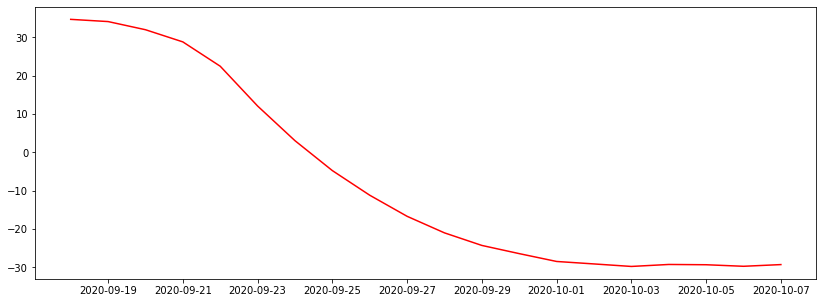

In [26]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2020-01-31'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['new_confirmed'], color='r', label='Predicted Confirmed Case')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['new_confirmed'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['new_confirmed'], color='b', label='Actual Confirmed Case')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Confirmed Cases', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()